In [1]:
# import packages
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from tensorflow import keras
import numpy as np

In [2]:
# load test data
input_path = 'H:\RediMinds\VCQI'
#train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test_30_day_complications.csv")

In [3]:
#x_train = train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
#y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels='30_day_COMPLICATIONS', axis = 'columns').copy()
y_test = test['30_day_COMPLICATIONS'].copy() 

In [4]:
# check % of pos labels in test set
#print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels test 0.09


In [5]:
# Generate prediction for the Random Forest Model
with open (input_path+'\cat_col_30_day_complications', 'rb') as fp:
    cat_col = pickle.load(fp)

model_path = 'output/models/'
from joblib import load
encoder = load(model_path+'OHE.joblib')

In [6]:
# Create dummy variables
one_hot_encoded_array = encoder.transform(x_test[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_test_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_test = x_test.merge(x_test_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_test = x_test.drop(labels = cat_col, axis = 'columns') # drop original variables

### Load Models

In [7]:
model_path = 'output/models/'

In [8]:
# import Decision Tree Classifier
from joblib import load
DTC = load(model_path+'DTC.joblib')


In [9]:
# import Random Forest Classifer
from joblib import load
RFR = load(model_path+'RFR.joblib')

In [10]:
# import Random Forest Classifer
from joblib import load
Logit = load(model_path+'Logit.joblib')

In [11]:
# load Neural Network Model
nn_model = keras.models.load_model(model_path+'nn_model.h5')

W0917 16:14:00.654296  7060 deprecation.py:323] From H:\Anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:1792: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Load Models trained using SMOTE

In [12]:
# import Decision Tree Classifier
from joblib import load
SMOTE_DTC = load(model_path+'SMOTE_DTC.joblib')


Using TensorFlow backend.


In [13]:
# import Random Forest Classifer
from joblib import load
SMOTE_RFR = load(model_path+'SMOTE_RFR.joblib')

In [14]:
# import Random Forest Classifer
from joblib import load
SMOTE_Logit = load(model_path+'SMOTE_Logit.joblib')

In [15]:
# load Neural Network Model
SMOTE_nn_model = keras.models.load_model(model_path+'SMOTE_nn_model.h5')

### Generate Predictions for the Test set

In [16]:
# Generate prediction for the Decsiion Tree Model
results_DTC = pd.DataFrame(DTC.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(DTC.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [17]:
# Generate prediction for the Random Forest Model
results_RFR = pd.DataFrame(RFR.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(RFR.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [18]:

# Generate prediction for the Logitic Regressions Model
results_Logit = pd.DataFrame(Logit.predict(x_test), columns=['pred_label'])
results_Logit['pred_prob'] =  pd.DataFrame(Logit.predict_proba(x_test))[1]
results_Logit['true_label'] = np.array(y_test)

In [19]:
# Generate prediction for Neural Network Model

# import Random Forest Classifer
from joblib import load
stdc = load(model_path+'nn_stdc.joblib')

#To prepare test data we will use test with one-hotcoded variables
nn_test = x_test.copy()
float_col = test.select_dtypes('float').columns
nn_test[float_col] = pd.DataFrame(stdc.transform(nn_test[float_col]),columns=float_col).copy()

# Generate prediction for the Neural Network Model
results_NN = pd.DataFrame(nn_model.predict(nn_test), columns=['pred_prob'])
results_NN['pred_label'] =  results_NN['pred_prob'].apply(lambda x: 1 if x>=0.5 else 0)
results_NN['true_label'] = np.array(y_test)

### Generate Predictions for Testset - SMOTE Models

In [20]:
# Generate prediction for the Decsiion Tree Model
results_SMOTE_DTC = pd.DataFrame(SMOTE_DTC.predict(x_test), columns=['pred_label'])
results_SMOTE_DTC['pred_prob'] =  pd.DataFrame(SMOTE_DTC.predict_proba(x_test))[1]
results_SMOTE_DTC['true_label'] = np.array(y_test)

In [21]:
# Generate prediction for the Random Forest Model
results_SMOTE_RFR = pd.DataFrame(SMOTE_RFR.predict(x_test), columns=['pred_label'])
results_SMOTE_RFR['pred_prob'] =  pd.DataFrame(SMOTE_RFR.predict_proba(x_test))[1]
results_SMOTE_RFR['true_label'] = np.array(y_test)

In [22]:
# Generate prediction for the Logistic Regressions Model
results_SMOTE_Logit = pd.DataFrame(SMOTE_Logit.predict(x_test), columns=['pred_label'])
results_SMOTE_Logit['pred_prob'] =  pd.DataFrame(SMOTE_Logit.predict_proba(x_test))[1]
results_SMOTE_Logit['true_label'] = np.array(y_test)

In [23]:
# Generate prediction for Neural Network Model
# Data has been already prepared in correct format above for Neural Network

# import Random Forest Classifer
from joblib import load
SMOTE_nn_stdc = load(model_path+'SMOTE_nn_stdc.joblib')

# Generate prediction for the Neural Network Model
results_SMOTE_NN = pd.DataFrame(SMOTE_nn_model.predict(nn_test), columns=['pred_prob'])
results_SMOTE_NN['pred_label'] =  results_SMOTE_NN['pred_prob'].apply(lambda x: 1 if x>=0.5 else 0)
results_SMOTE_NN['true_label'] = np.array(y_test)

### Performance of the models for the testset

In [24]:
# Define function to calculate Precision-Recall Curve
def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc


print("AUC-ROC DTC: {:.3f}".format(metrics.roc_auc_score(results_DTC['true_label'], results_DTC['pred_prob'])))
print("AUC-ROC LOGIT: {:.3f}".format(metrics.roc_auc_score(results_Logit['true_label'], results_Logit['pred_prob'])))
print("AUC-ROC RFR: {:.3f}".format(metrics.roc_auc_score(results_RFR['true_label'], results_RFR['pred_prob'])))
print("AUC-ROC NN: {:.3f}".format(metrics.roc_auc_score(results_NN['true_label'], results_NN['pred_prob'])))


print("PR-AUC DTC: {:.3f}".format(calc_aucpr_data(results_DTC)))
print("PR-AUC LOGIT: {:.3f}".format(calc_aucpr_data(results_Logit)))
print("PR-AUC RFR: {:.3f}".format(calc_aucpr_data(results_RFR)))
print("PR-AUC NN: {:.3f}".format(calc_aucpr_data(results_NN)))


AUC-ROC DTC: 0.663
AUC-ROC LOGIT: 0.791
AUC-ROC RFR: 0.826
AUC-ROC NN: 0.778
PR-AUC DTC: 0.195
PR-AUC LOGIT: 0.266
PR-AUC RFR: 0.376
PR-AUC NN: 0.229


H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


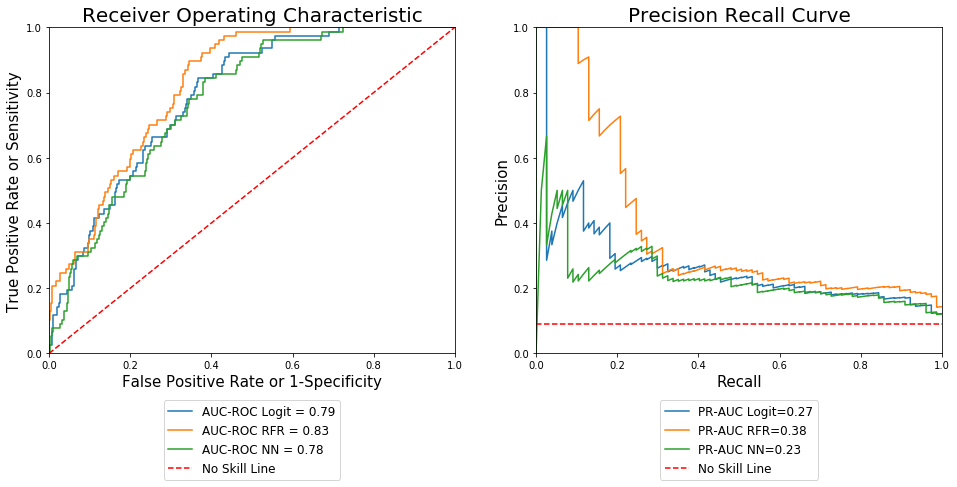

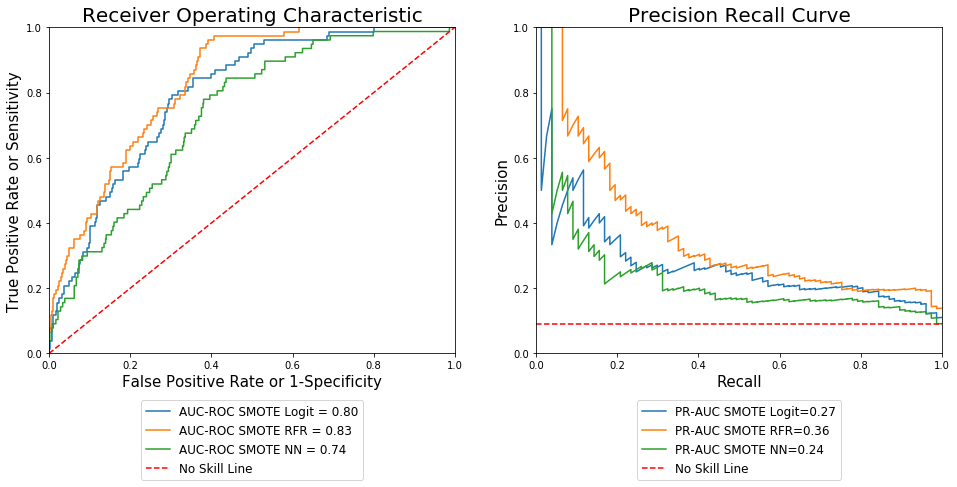

In [25]:
%matplotlib inline

# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    mortality_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, mortality_ratio

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
fpr_Logit, tpr_Logit, thresholds_Logit, roc_auc_Logit = calc_aucroc_data(results_Logit)
fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
fpr_NN, tpr_NN, thresholds_NN, roc_auc_NN = calc_aucroc_data(results_NN)

recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, mortality_ratio = calc_aucpr_data(results_DTC)
recall_Logit, precision_Logit, f1_Logit, prc_auc_Logit, mortality_ratio = calc_aucpr_data(results_Logit)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, mortality_ratio = calc_aucpr_data(results_RFR)
recall_NN, precision_NN, f1_NN, prc_auc_NN, mortality_ratio = calc_aucpr_data(results_NN)


# Plotting performance of models developed using original data
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})

#ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC-ROC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_Logit, tpr_Logit, label = 'AUC-ROC Logit = %0.2f' % roc_auc_Logit)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC-ROC RFR = %0.2f' % roc_auc_RFR)
ax1.plot(fpr_NN, tpr_NN, label = 'AUC-ROC NN = %0.2f' % roc_auc_NN)

ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})

#ax2.plot(recall_DTC, precision_DTC, label = 'PR-AUC DTC=%.2f' % (prc_auc_DTC))
ax2.plot(recall_Logit, precision_Logit, label = 'PR-AUC Logit=%.2f' % (prc_auc_Logit))
ax2.plot(recall_RFR, precision_RFR, label = 'PR-AUC RFR=%.2f' % (prc_auc_RFR))
ax2.plot(recall_NN, precision_NN, label = 'PR-AUC NN=%.2f' % (prc_auc_NN))

positive_class_ratio = mortality_ratio
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
fig.show()



#fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_SMOTE_DTC)
fpr_Logit, tpr_Logit, thresholds_Logit, roc_auc_Logit = calc_aucroc_data(results_SMOTE_Logit)
fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_SMOTE_RFR)
fpr_NN, tpr_NN, thresholds_NN, roc_auc_NN = calc_aucroc_data(results_SMOTE_NN)

#recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, mortality_ratio = calc_aucpr_data(results_SMOTE_DTC)
recall_Logit, precision_Logit, f1_Logit, prc_auc_Logit, mortality_ratio = calc_aucpr_data(results_SMOTE_Logit)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, mortality_ratio = calc_aucpr_data(results_SMOTE_RFR)
recall_NN, precision_NN, f1_NN, prc_auc_NN, mortality_ratio = calc_aucpr_data(results_SMOTE_NN)

# Plotting performance of models developed using original data
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})

#ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC-ROC SMOTE DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_Logit, tpr_Logit, label = 'AUC-ROC SMOTE Logit = %0.2f' % roc_auc_Logit)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC-ROC SMOTE RFR = %0.2f' % roc_auc_RFR)
ax1.plot(fpr_NN, tpr_NN, label = 'AUC-ROC SMOTE NN = %0.2f' % roc_auc_NN)

ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})

#ax2.plot(recall_DTC, precision_DTC, label = 'PR-AUC SMOTE DTC=%.2f' % (prc_auc_DTC))
ax2.plot(recall_Logit, precision_Logit, label = 'PR-AUC SMOTE Logit=%.2f' % (prc_auc_Logit))
ax2.plot(recall_RFR, precision_RFR, label = 'PR-AUC SMOTE RFR=%.2f' % (prc_auc_RFR))
ax2.plot(recall_NN, precision_NN, label = 'PR-AUC SMOTE NN=%.2f' % (prc_auc_NN))

positive_class_ratio = mortality_ratio
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
fig.show()


H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


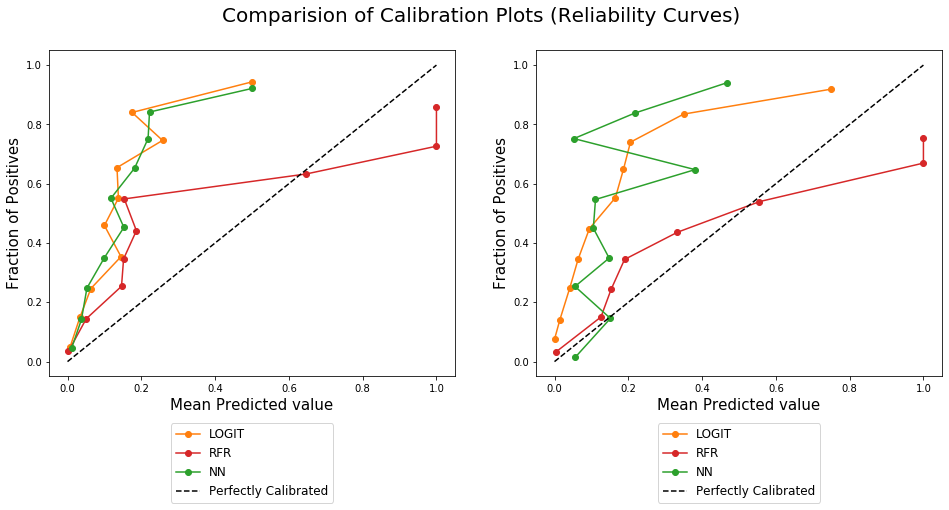

In [26]:
# Plotting Calibration curve
from sklearn.calibration import calibration_curve

def calib_curve(result):
    x, y = calibration_curve(result['true_label'],result['pred_prob'],n_bins = 10, strategy='uniform')
    return x, y

x_DTC, y_DTC = calib_curve(results_DTC)
x_Logit, y_Logit = calib_curve(results_Logit)
x_RFR, y_RFR = calib_curve(results_RFR)
x_NN, y_NN = calib_curve(results_NN)

x_SMOTE_DTC, y_SMOTE_DTC = calib_curve(results_SMOTE_DTC)
x_SMOTE_Logit, y_SMOTE_Logit = calib_curve(results_SMOTE_Logit)
x_SMOTE_RFR, y_SMOTE_RFR = calib_curve(results_SMOTE_RFR)
x_SMOTE_NN, y_SMOTE_NN = calib_curve(results_SMOTE_NN)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Comparision of Calibration Plots (Reliability Curves)', fontsize=20)

#ax1.plot(x_DTC, y_DTC, marker = 'o', color = 'tab:blue', label = 'DTC')
ax1.plot(x_Logit, y_Logit, marker = 'o', color = 'tab:orange', label = 'LOGIT')
ax1.plot(x_RFR, y_RFR, marker = 'o', color = 'tab:red', label = 'RFR')
ax1.plot(x_NN, y_NN, marker = 'o', color = 'tab:green', label = 'NN')

ax1.plot([0, 1], [0, 1],linestyle='--',color='black', label = 'Perfectly Calibrated')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
ax1.set_ylabel('Fraction of Positives',fontdict={"size":15})
ax1.set_xlabel('Mean Predicted value',fontdict={"size":15})

#ax2.plot(x_SMOTE_DTC, y_SMOTE_DTC, marker = 'o', color = 'tab:blue', label = 'DTC')
ax2.plot(x_SMOTE_Logit, y_SMOTE_Logit, marker = 'o', color = 'tab:orange', label = 'LOGIT')
ax2.plot(x_SMOTE_RFR, y_SMOTE_RFR, marker = 'o', color = 'tab:red', label = 'RFR')
ax2.plot(x_SMOTE_NN, y_SMOTE_NN, marker = 'o', color = 'tab:green', label = 'NN')

ax2.plot([0, 1], [0, 1],linestyle='--',color='black', label = 'Perfectly Calibrated')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
ax2.set_ylabel('Fraction of Positives',fontdict={"size":15})
ax2.set_xlabel('Mean Predicted value',fontdict={"size":15})

fig.show()